### LSTM 함번 써볼라꼬예

In [2]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt


### Load Data

In [3]:
path = "../data/"

train = pd.read_csv(path+"train.csv").assign(_type="train")
test = pd.read_csv(path+"test.csv").assign(_type="test")
submission = pd.read_csv(path+"test.csv")
df = pd.concat([train, test], axis=0)

In [4]:
prefixes = ["HOURLY_NETWORK-DATA_",
            "HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD",
            "HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX",
            "HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE",
            "HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL",
            "HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL",
            "HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_ALL_EXCHANGE"]

file_names = [
    f for f in os.listdir(path)
    if any(f.startswith(prefix) for prefix in prefixes) and f.endswith(".csv")
]
display(file_names)
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(path+f) for f in file_names
}


for _file_name, _df in tqdm(file_dict.items()):
    _rename_rule = {
        col: f"{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


['HOURLY_NETWORK-DATA_TRANSACTIONS-COUNT.csv',
 'HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_ALL_EXCHANGE.csv',
 'HOURLY_NETWORK-DATA_BLOCK-INTERVAL.csv',
 'HOURLY_NETWORK-DATA_ADDRESSES-COUNT.csv',
 'HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX.csv',
 'HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL.csv',
 'HOURLY_NETWORK-DATA_HASHRATE.csv',
 'HOURLY_NETWORK-DATA_BLOCKREWARD.csv',
 'HOURLY_NETWORK-DATA_SUPPLY.csv',
 'HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE.csv',
 'HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD.csv',
 'HOURLY_NETWORK-DATA_BLOCK-COUNT.csv',
 'HOURLY_NETWORK-DATA_UTXO-COUNT.csv',
 'HOURLY_NETWORK-DATA_BLOCK-BYTES.csv',
 'HOURLY_NETWORK-DATA_FEES-TRANSACTION.csv',
 'HOURLY_NETWORK-DATA_TOKENS-TRANSFERRED.csv',
 'HOURLY_NETWORK-DATA_FEES.csv',
 'HOURLY_NETWORK-DATA_VELOCITY.csv',
 'HOURLY_NETWORK-DATA_DIFFICULTY.csv',
 'HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL.csv']

100%|██████████| 20/20 [00:00<00:00, 30.96it/s]


### EDA (Explanatory Data Analysis)

##### 누락 값 확인

In [5]:
# 누락된 값을 백분율로 나타내기
eda_df = df.loc[df["_type"] == "train"]
missing_values = eda_df.isnull().sum()
missing_percentage = (missing_values / len(eda_df)) * 100
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

transactions_count_mean        0.216895
block_interval                 0.216895
difficulty                     0.216895
fees_transaction_mean          0.216895
block_bytes                    0.216895
fees_transaction_mean_usd      0.216895
tokens_transferred_mean        0.216895
fees_block_mean                0.216895
fees_block_mean_usd            0.216895
fees_reward_percent            0.216895
coinbase_premium_gap           0.057078
coinbase_premium_index         0.057078
target                         0.000000
_type                          0.000000
addresses_count_receiver       0.000000
addresses_count_sender         0.000000
addresses_count_active         0.000000
taker_buy_sell_ratio           0.000000
taker_buy_ratio                0.000000
taker_sell_ratio               0.000000
taker_sell_volume              0.000000
taker_buy_volume               0.000000
ID                             0.000000
transactions_count_total       0.000000
blockreward_usd                0.000000


In [6]:
# len(sorted_missing_percentage[sorted_missing_percentage == 100.0].index)

# for idx, val in sorted_missing_percentage.items():
#     print(f'Index: {idx}, Value: {val}')

# eda_df = df.drop(sorted_missing_percentage[sorted_missing_percentage == 100.0].index, axis=1)

In [7]:
# # 몇 개 컬럼으로 EDA 예제
# cols_dict: Dict[str, str] = {
#     "ID": "ID",
#     "target": "target",
# }
# # 추출후 단순화를 위해 rename
# eda_df = eda_df[cols_dict.keys()].rename(cols_dict, axis=1)

##### 레이블 분포

In [8]:
# 타겟 레이블 분포 -> 으으음 왜이랫!!!
eda_df["target"].value_counts()/len(eda_df)

target
2.0    0.419064
1.0    0.404566
3.0    0.091895
0.0    0.084475
Name: count, dtype: float64

##### 독립변수 간의 상관계수

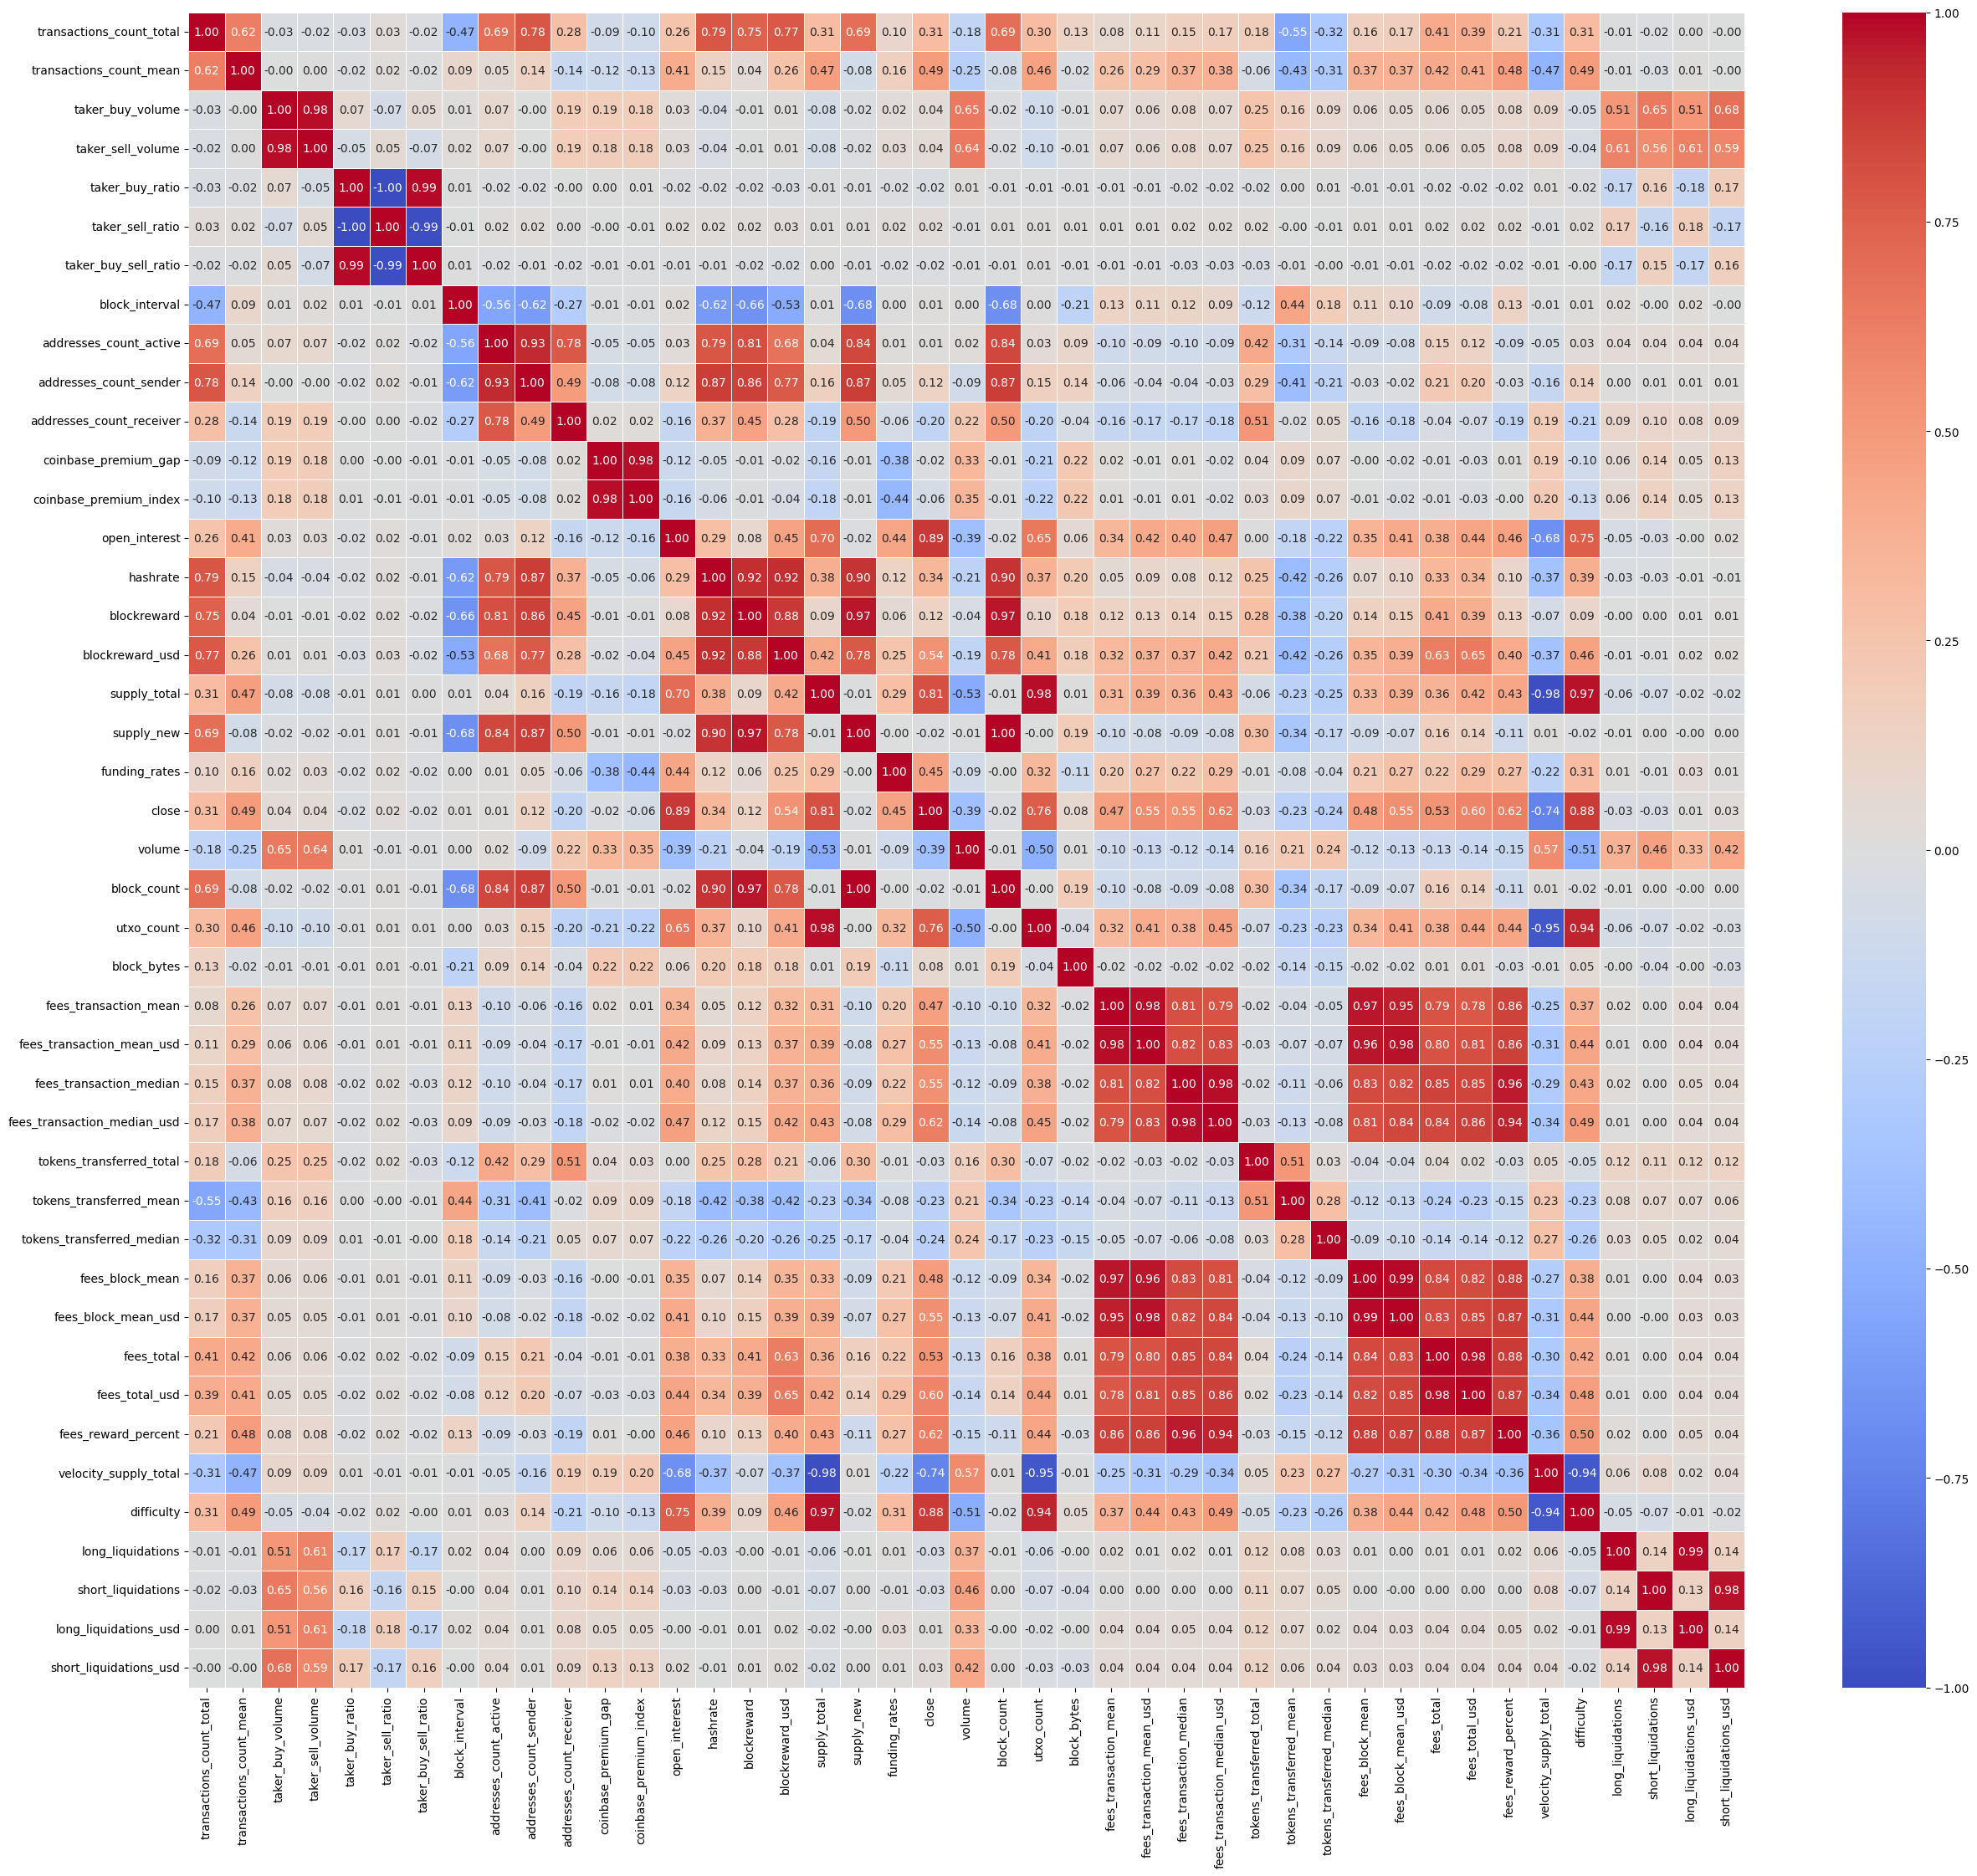

In [9]:
# 상관계수 확인
correlation_matrix = eda_df.iloc[:,3:].corr()

plt.figure(figsize=(30, 26))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

plt.show()

##### 가격 변동에 따른 독립변수들의 변화 확인하기

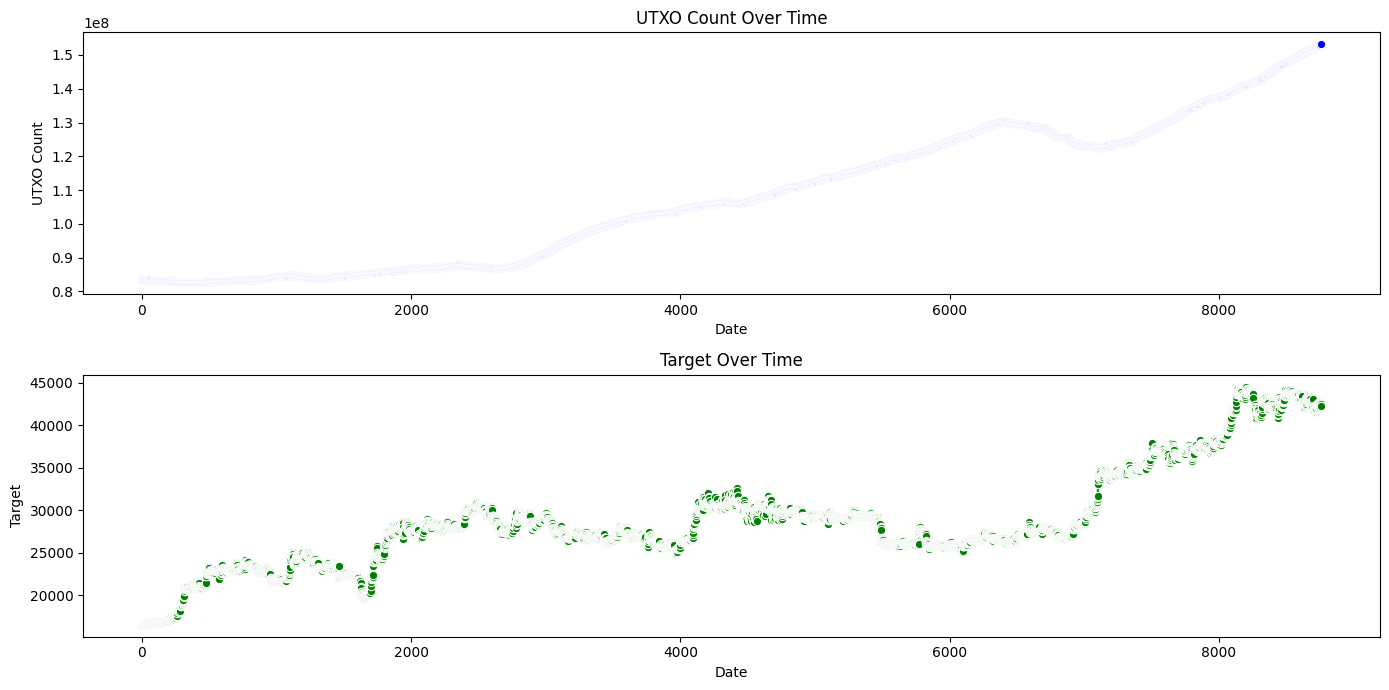

In [10]:

plt.figure(figsize=(14, 7))

# UTXO Count 시각화
plt.subplot(2, 1, 1)
sns.lineplot(data=eda_df, x=eda_df.index, y='utxo_count', marker='o', color='blue')
plt.title('UTXO Count Over Time')
plt.xlabel('Date')
plt.ylabel('UTXO Count')

# Target 시각화
plt.subplot(2, 1, 2)
sns.lineplot(data=eda_df, x=eda_df.index, y='close', marker='o', color='green')
plt.title('Target Over Time')
plt.xlabel('Date')
plt.ylabel('Target')

plt.tight_layout()
plt.show()


UTXO Count와 close 가격의 변동은 어때요??? 비슷해보이나요?

제가 생각하기에 시간이 지남에 따라 오르고 있는 것은 맞지만 

이것은 각 변수들의 독립적인 특징일 수도 있을 것 같다는 생각이 드네요.

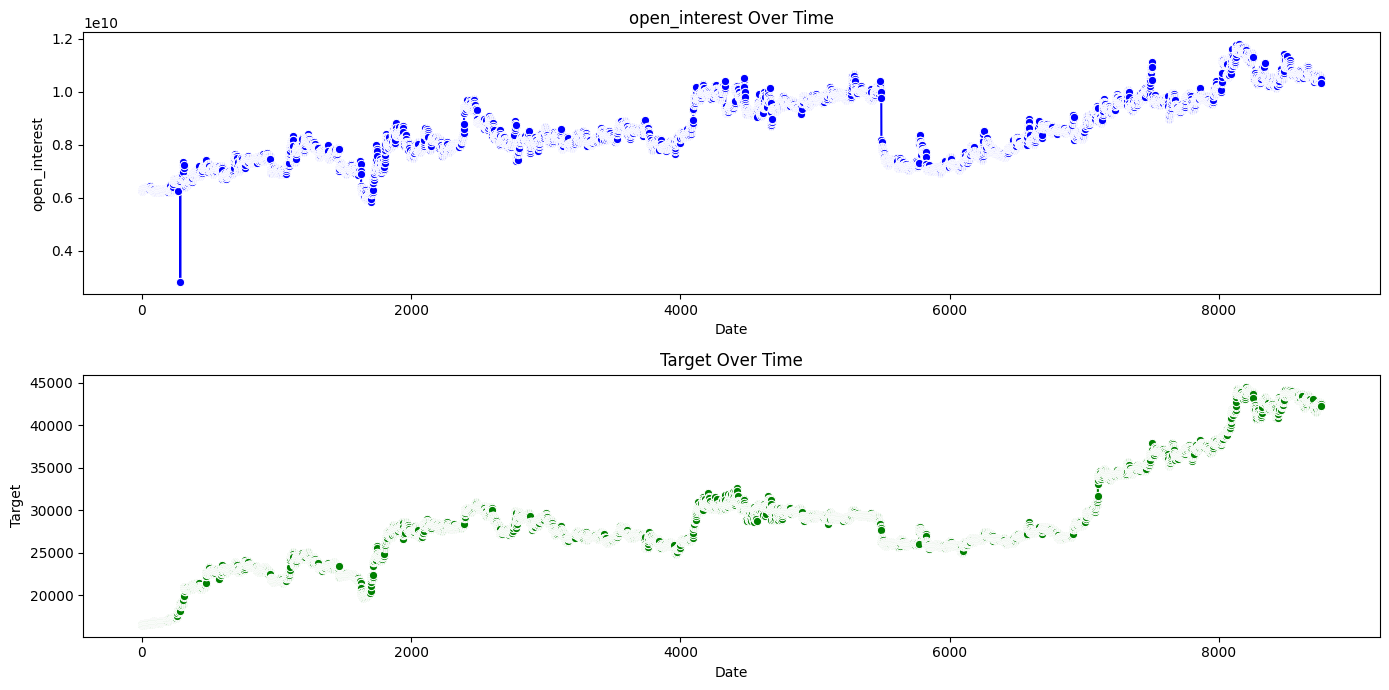

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(14, 7))

# UTXO Count 시각화
plt.subplot(2, 1, 1)
sns.lineplot(data=eda_df, x=eda_df.index, y='open_interest', marker='o', color='blue')
plt.title('open_interest Over Time')
plt.xlabel('Date')
plt.ylabel('open_interest')

# Target 시각화
plt.subplot(2, 1, 2)
sns.lineplot(data=eda_df, x=eda_df.index, y='close', marker='o', color='green')
plt.title('Target Over Time')
plt.xlabel('Date')
plt.ylabel('Target')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

open intereset와 close 가격의 변동은 

어때요??? 비슷해보이지 않나요? 

등락에 따라서 그래프 움직임이 좀 비슷해보여요

### Feature engineering

In [12]:
# 전체 독립변수에서 내가 사용할 독립변수 고르기
features = ['ID', 'target', '_type', 'funding_rates', 'open_interest',
       'taker_buy_volume', 'taker_sell_volume', 'taker_buy_ratio',
       'taker_sell_ratio', 'taker_buy_sell_ratio', 'difficulty',
       'transactions_count_total', 'transactions_count_mean', 'block_count',
       'fees_transaction_mean', 'fees_transaction_mean_usd',
       'fees_transaction_median', 'fees_transaction_median_usd',
       'fees_block_mean', 'fees_block_mean_usd', 'fees_total',
       'fees_total_usd', 'fees_reward_percent', 'hashrate', 'utxo_count',
       'tokens_transferred_total', 'tokens_transferred_mean',
       'tokens_transferred_median', 'block_interval', 'velocity_supply_total',
       'supply_total', 'supply_new', 'addresses_count_active',
       'addresses_count_sender', 'addresses_count_receiver',
       'blockreward', 'blockreward_usd', 'liquidation_diff',
       'liquidation_usd_diff', 'volume_diff', 'liquidation_diffg',
       'liquidation_usd_diffg', 'volume_diffg', 'buy_sell_volume_ratio']
fe = ['ID', 'target', '_type', 'funding_rates', 'long_liquidations',
       'short_liquidations', 'long_liquidations_usd', 'short_liquidations_usd',
       'coinbase_premium_gap', 'coinbase_premium_index', 'open_interest',
       'taker_buy_volume', 'taker_sell_volume', 'taker_buy_ratio',
       'taker_sell_ratio', 'taker_buy_sell_ratio', 'difficulty',
       'transactions_count_total', 'transactions_count_mean', 'block_count',
       'fees_transaction_mean', 'fees_transaction_mean_usd',
       'fees_transaction_median', 'fees_transaction_median_usd',
       'fees_block_mean', 'fees_block_mean_usd', 'fees_total',
       'fees_total_usd', 'fees_reward_percent', 'hashrate', 'utxo_count',
       'tokens_transferred_total', 'tokens_transferred_mean',
       'tokens_transferred_median', 'block_interval', 'velocity_supply_total',
       'supply_total', 'supply_new', 'addresses_count_active',
       'addresses_count_sender', 'addresses_count_receiver', 'block_bytes',
       'blockreward', 'blockreward_usd']

new_features = [x for x in fe if x not in features]

In [13]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["taker_buy_volume"] - df["taker_sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["taker_buy_volume"] - df["taker_sell_volume"]),
    buy_sell_volume_ratio=df["taker_buy_volume"] / (df["taker_sell_volume"] + 1),
)
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in (df.columns)[3:] if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
]

In [14]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [15]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)
df = df.loc[:, ~df.columns.duplicated()]
df = df.drop(columns=new_features)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

### Model Training

In [31]:
# train_test_split으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis=1),
    train_df["target"].astype(int),
    test_size=0.2,
    random_state=42,
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Train 데이터 Scaling 및 Reshape
X_scaled_train = scaler.fit_transform(x_train)
X_scaled_train_reshaped = X_scaled_train.reshape((X_scaled_train.shape[0], 1, X_scaled_train.shape[1]))

# Valid 데이터 Scaling 및 Reshape
X_scaled_valid = scaler.transform(x_valid)  # fit_transform이 아닌 transform
X_scaled_valid_reshaped = X_scaled_valid.reshape((X_scaled_valid.shape[0], 1, X_scaled_valid.shape[1]))

# 모델 구성
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(1, X_scaled_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
model.fit(X_scaled_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# 모델 평가 및 예측
loss, accuracy = model.evaluate(X_scaled_valid_reshaped, y_valid)
print(f"Model Loss: {loss}, Accuracy: {accuracy}")

# 예측
predictions = model.predict(X_scaled_valid_reshaped)
predicted_classes = np.argmax(predictions, axis=1)
print(f"Predictions: {predictions}")


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4057 - loss: 1.2142 - val_accuracy: 0.4230 - val_loss: 1.1281
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4621 - loss: 1.0778 - val_accuracy: 0.4194 - val_loss: 1.1329
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4979 - loss: 1.0389 - val_accuracy: 0.4237 - val_loss: 1.1369
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5385 - loss: 0.9778 - val_accuracy: 0.4308 - val_loss: 1.1823
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5914 - loss: 0.8889 - val_accuracy: 0.4294 - val_loss: 1.2180
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6477 - loss: 0.8108 - val_accuracy: 0.4215 - val_loss: 1.3175
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7040 - loss: 0.7016 - val_accuracy: 0.4165 - val_loss: 1.3942
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7474 - loss: 0.6091 - val_accuracy: 0.4223 - val_

In [34]:
accuracy = accuracy_score(y_valid, predicted_classes)
accuracy

0.4126712328767123

In [25]:
def round_based_on_half(number):
    return np.floor(number + 0.5).astype(int)

rounded_list = [round_based_on_half(x) for x in predictions]


accuracy = accuracy_score(y_valid, rounded_list)

print(f"acc: {accuracy}")

acc: 0.4166666666666667


In [40]:
# train, valid 데이터를 합쳐서 재학습용 데이터로 변환
X_total = np.vstack((x_train, x_valid))  # x_train과 x_valid를 세로로 합침
y_total = np.hstack((y_train, y_valid))  # y_train과 y_valid를 가로로 합침

# 전체 데이터를 다시 Scaling
X_total_scaled = scaler.fit_transform(X_total)
X_total_scaled_reshaped = X_total_scaled.reshape((X_total_scaled.shape[0], 1, X_total_scaled.shape[1]))

# 새로운 모델을 정의하거나 기존 모델을 재사용할 수 있음
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(1, X_total_scaled.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train + valid 데이터를 이용한 재학습
model.fit(X_total_scaled_reshaped, y_total, epochs=10, batch_size=32)

# test_df 전처리
# train_df와 동일하게 'ID' 열만 제거
X_test = test_df.drop(["ID", 'target'], axis=1)

# test_df의 feature 수가 train_df와 동일한지 확인
print(f"Train Features: {x_train.shape[1]}, Test Features: {X_test.shape[1]}")

# Scaling 및 Reshape (train에 사용한 scaler로 test도 동일하게 적용)
X_test_scaled = scaler.transform(X_test)
X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 모델을 사용하여 예측 수행
test_predictions = model.predict(X_test_scaled_reshaped)

# 각 샘플에 대해 가장 높은 확률을 가진 클래스 선택
predicted_test_classes = np.argmax(test_predictions, axis=1)

print(f"Test Predictions: {predicted_test_classes}")




Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4138 - loss: 1.1863
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4791 - loss: 1.0738
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5307 - loss: 1.0060
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9173
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6333 - loss: 0.8406
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6703 - loss: 0.7570
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7157 - loss: 0.6662
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7542 - loss: 0.5928
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7866 - loss: 0.5257
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8131 - loss: 0.4759
Train Features: 1193, Test Features: 1193


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Predictions: [1 2 1 ... 1 1 1]


### Inference

In [21]:
predictions = model.predict(x_valid)
rounded_list = [round_based_on_half(x) for x in predictions]

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step


### Output File Save

In [41]:
submission = submission.assign(target = predicted_test_classes)
submission.to_csv("output5.csv", index=False)